In [1]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724

/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724


In [4]:
!pip install fmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 13.5 MB/s eta 0:00:00


In [5]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from fmpy.util import plot_result, download_test_file
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

import random
import numpy as np
import torch
import argparse
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras

from collections import deque
import numpy as np
from tqdm import tqdm

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import scipy.signal
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch import FloatTensor as FT

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

import pickle
import math

In [6]:
fmu_filename = 'HEV_TMED_Simulator_Rearrange_230711_linux.fmu'
start_time = 0.0
stop_time = 1800.0
step_size = 1
soc_init = 67

# WLTP profile에 대하여 시험
with open("wltp_vehicle_speed_profile_real.csv") as file_name:
    vehicle_speed_profile = np.loadtxt(file_name, delimiter=",")

EngLine = pd.read_csv('wltp_EngLine_rule_based_10Hz.csv')
EngLine = np.array(EngLine['EngLine'])

In [7]:
class HEV:
    def __init__(self, fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile):
        self.fmu_filename = fmu_filename
        self.vrs = {}
        self.start_time = start_time
        self.stop_time = stop_time
        self.step_size = step_size
        self.time = self.start_time
        self.vehicle_speed_profile = vehicle_speed_profile
        self.soc_init = soc_init/5000
        self.soc_base = soc_init/5000
        self.state_init = np.array([self.soc_init, 0, 0]).reshape(1,-1)
        self.state = np.array([self.soc_init, 0, 0]).reshape(1,-1)
        self.action_upper_bound = 15000
        self.action_lower_bound = -15000
        #self.action_space = [[13500, 2000], [500, 2000], [13500, -15000], [500, -15000]]
        self.obssize = len(self.state[0])
        self.actsize = 2

        model_description = read_model_description(self.fmu_filename)
        for variable in model_description.modelVariables:
            self.vrs[variable.name] = variable.valueReference
        unzipdir = extract(fmu_filename)
        self.fmu = FMU2Slave(guid=model_description.guid,
                       unzipDirectory=unzipdir,
                       modelIdentifier=model_description.coSimulation.modelIdentifier,
                       instanceName='instance1')

    def step(self, action):
        #a = self.action_space[action]
#         action = action*self.action_upper_bound
        a1 = action[0]*self.action_upper_bound
        a2 = action[0]*self.action_upper_bound
        a3 = self.soc_init*5000
        a4 = action[1]/2 + 1
        instant_veh_speed = np.interp(self.time, self.vehicle_speed_profile[:,0], self.vehicle_speed_profile[:,1])
        self.fmu.setReal([self.vr_input1, self.vr_input2, self.vr_input3, self.vr_input4, self.vr_input5], [instant_veh_speed, a1, a2, a3, a4]) #input variable, input key(13500 2000)
        self.fmu.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size)
#         [output1, output2, output3, output4, output5, output6, output7] = self.fmu.getReal([self.vr_output1,self.vr_output2, self.vr_output3, self.vr_output4, self.vr_output5, self.vr_output6, self.vr_output7])
#         self.state = [output1, output2, output3, output4, output5, output6, output7]
        state = np.array(self.fmu.getReal(np.arange(35)))/5000
        state_column = np.array([self.vrs['Bat_SOC'], self.vrs['BSFC_g_kWh[1]'], self.vrs['Driver_sVeh_kph']])
        self.state = state[state_column]
        soc = state[self.vrs['Bat_SOC']]
        BSFC = state[self.vrs['BSFC_g_kWh[1]']]
        reward = 1 - 10000*(self.soc_init - soc) ** 2 - BSFC
        is_done = lambda time: time >= self.stop_time
        info = state[np.array([self.vrs['Bat_SOC'], self.vrs['nEngOn'], self.vrs['PT_tqTmInDmd_Nm_P2'], self.vrs['ObEng_nEng_Rpm'], self.vrs['TrEtp_tqEngMAF_Nm'], self.vrs['TrP0_tqP0_Nm'], self.vrs['TrP2_tqP2_Nm'], self.vrs['Driver_sVeh_kph'], self.vrs['BSFC_g_kWh[1]']])]
        self.time += self.step_size
        return self.state.reshape(1,-1), reward, is_done(self.time), info

    def reset(self):
        self.fmu.instantiate()
        self.fmu.setupExperiment(startTime=self.start_time)
        self.fmu.enterInitializationMode()
        self.fmu.exitInitializationMode()
        self.state = self.state_init
        self.time = self.start_time

        self.vr_input1 = self.vrs['Driver_sVeh_Target_kph']
        self.vr_input2 = self.vrs['Engine_on_line']
        self.vr_input3 = self.vrs['Engine_off_line']
        self.vr_input4 = self.vrs['soc_init']
        self.vr_input5 = self.vrs['Engine_OOL']
        self.vr_output1 = self.vrs['TgMod_fPt']
        self.vr_output2 = self.vrs['P2_wElec_W']
        self.vr_output3 = self.vrs['P4_wElec_W']
        self.vr_output4 = self.vrs['ObP2_wElecBIntv_W']
        self.vr_output5 = self.vrs['EV_on_line']
        self.vr_output6 = self.vrs['EV_off_line']
        self.vr_output7 = self.vrs['Bat_SOC']
        self.vr_output8 = self.vrs['PT_tqTmInDmd_Nm_P2']
        self.vr_output9 = self.vrs['P0_wElec_W']
        self.vr_output10 = self.vrs['Pwr_Aux_W']
        self.vr_output11 = self.vrs['ObEng_nEng_Rpm']
        self.vr_output12 = self.vrs['TrEtp_tqEngMAF_Nm']
        self.vr_output13 = self.vrs['rpm_P0']
        self.vr_output14 = self.vrs['TM_F_nTmIn_rpm']
        self.vr_output15 = self.vrs['TM_R_nTmIn_rpm']
        self.vr_output16 = self.vrs['eBat_kWh']
        self.vr_output17 = self.vrs['nEngOn']
        self.vr_output18 = self.vrs['TrP0_tqP0_Nm']
        self.vr_output19 = self.vrs['TrP2_tqP2_Nm']
        self.vr_output20 = self.vrs['TrP4_tqP4_Nm']
        self.vr_output21 = self.vrs['TCU_F_fCurGe']
        self.vr_output22 = self.vrs['TCU_F_fTarGe']
        self.vr_output23 = self.vrs['Driver_sVeh_kph']
        self.vr_output24 = self.vrs['Eng_eff_avg']
        self.vr_output25 = self.vrs['TM_F_P0P2_eff_avg']
        self.vr_output26 = self.vrs['TM_F_P0P4_eff_avg']
        self.vr_output27 = self.vrs['BSFC_g_kWh[1]']
        self.vr_output28 = self.vrs['BSFC_g_kWh[2]']
        self.vr_output29 = self.vrs['BSFC_g_kWh[3]']

        return self.state.reshape(1,-1)

In [8]:
state1_num = 20
state2_num = 7
action_num = 21**2

state_num_ = 100

SOC_interval = np.arange(0,20) * 0.001 # SOC 5% 간격
Vel_interval = np.arange(0,6)*20/5000  # velocity 20km/h 간격

SOC_interval_ = np.arange(0,100) * 1/5000 # SOC 5% 간격

def state_index(state1, state2): # SOC, Velocity
  s1, s2 = 0,0
  # s1 = 0
  for i in range(len(SOC_interval)):
    if SOC_interval[i] < state1:
      s1+=1
  for i in range(len(Vel_interval)):
    if Vel_interval[i] < state2:
      s2+=1
  return s1, s2

def state_index_(state): # SOC
  s = 0
  for i in range(len(SOC_interval_)):
    if SOC_interval_[i] < state:
      s+=1
  return s

def state_index__(state): # SOC
  return np.argmin(np.abs(SOC_interval_-state))

action_grid = []
for i in np.linspace(-1,1,int(math.sqrt(action_num))):
  for j in np.linspace(-1,1,int(math.sqrt(action_num))):
    action_grid.append([i,j])

# def action_index(action):
#   action = np.array(action)
#   action_list = [np.sum(np.abs(action-np.array(action_discrete))) for action_discrete in action_grid]
#   return np.argmin(action_list)

In [ ]:
transition_mtx_1206 = np.zeros([state_num_, action_num, state_num_])
reward_list_1206 = [[[] for i in range(action_num)] for j in range(state_num_)]
action_flag = False

start = time.time()
for ep in range(5000):
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  s = env.reset()
  done = False
  step=0
  prev_state = state_index__(s[0][0])

  while done == False:
    action = [np.random.rand()*(-1)**np.random.randint(0,1),np.random.rand()*(-1)**np.random.randint(0,1)]
    index = action_index(action)
    s,r,done,_ = env.step(action)
    curr_state = state_index__(s[0][0])

    reward_list_1206[prev_state][index].append(r)
    if step > 0:
      transition_mtx_1206[prev_state][index][curr_state] += 1

    prev_state = curr_state
    step+=1
  if (ep+1)%500==0:
    print('episode ', ep+1,  ' saved!')
    print(time.time()-start)
    with open('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/reward_list_1206.pkl',"wb") as f:
      pickle.dump(reward_list_1206, f)
    np.save('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/transition_mtx_1206.npy', transition_mtx_1206)

episode  500  saved!
2509.4772861003876
episode  1000  saved!
5025.774782419205
episode  1500  saved!
7559.747351646423


In [11]:
action_num, state1_num

(441, 20)

In [14]:
transition_mtx = np.zeros([state1_num, action_num, state1_num])
reward_list = [[[] for i in range(action_num)] for j in range(state1_num)]
# transition_mtx_ = np.zeros([state1_num,state2_num,action_num,state1_num,state2_num])
# reward_list_ = [[[[] for i in range(action_num)] for k in range(state2_num)] for j in range(state1_num)]
# action_flag = False
# transition_mtx = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/1125/transition_mtx.npy')
# transition_mtx_ = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/1125/transition_mtx_.npy')

start = time.time()
for ep in range(3000):
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  s = env.reset()
  prev1, prev2 = state_index(s[0][0], s[0][1])
  done = False
  action_flag = False
  if ep <=action_num*5-1:
    action_index = ep%action_num
  else:
    action_flag = True
  step=0

  while done == False:
    if action_flag == True:
      action_index = random.randint(0,action_num-1)
    s,r,done,_ = env.step(action_grid[action_index])
    state1, state2 = state_index(s[0][0],s[0][-1])
    reward_list[prev1][action_index].append(r)
    # reward_list_[state1][state2][action_index].append(r)

    transition_mtx[prev1][action_index][state1] += 1
      # transition_mtx_[prev1][prev2][action_index][state1][state2] += 1

    prev1, prev2 = state1, state2

    step+=1
  if (ep+1)%500==0:
    print('episode ', ep,  ' saved!')
    print(time.time()-start)
    with open('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/reward_list.pkl',"wb") as f:
      pickle.dump(reward_list, f)
    # with open('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/reward_list_.pkl',"wb") as g:
    #   pickle.dump(reward_list_, g)
    np.save('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/transition_mtx.npy', transition_mtx)
    # np.save('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/transition_mtx_.npy', transition_mtx_)

episode  499  saved!
671.3240678310394
episode  999  saved!
1380.7939202785492
episode  1499  saved!
2051.354330062866
episode  1999  saved!
2729.171625852585
episode  2499  saved!
3419.442051887512
episode  2999  saved!
4124.848947048187


In [10]:
random.randint(0,100)

5

In [ ]:
transition_mtx__ = np.zeros([state_num_, action_num, state_num_])
reward_list__ = [[[] for i in range(action_num)] for j in range(state_num_)]
action_flag = False

start = time.time()
for ep in range(5000):
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  env.reset()
  done = False
  if ep <=action_num*10-1:
    action_index = ep%action_num
  else:
    action_flag = True
  step=0

  while done == False:
    if action_flag == True:
      action_index = random.randint(0,action_num-1)
    s,r,done,_ = env.step(action_grid[action_index])
    state = state_index_(s[0][0])
    reward_list__[state][action_index].append(r)

    if step > 0:
      transition_mtx__[prev][action_index][state] += 1

    prev = state
    step+=1
  if (ep+1)%500==0:
    print('episode ', ep,  ' saved!')
    print(time.time()-start)
    with open('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/reward_list__.pkl',"wb") as f:
      pickle.dump(reward_list__, f)
    np.save('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/transition_mtx__.npy', transition_mtx__)

episode  499  saved!
713.0395240783691
episode  999  saved!
1405.7688200473785
episode  1499  saved!
2104.5771374702454
episode  1999  saved!
2807.5459077358246
episode  2499  saved!
3513.902813434601
episode  2999  saved!
4236.238867759705
episode  3499  saved!
4963.760825872421
episode  3999  saved!
5696.588049173355
episode  4499  saved!
6436.1833345890045
episode  4999  saved!
7180.448302268982


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/1205/reward_list.pkl',"rb") as f:
	reward_list = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/1205/reward_list_.pkl',"rb") as f:
	reward_list_ = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/1205/reward_list__.pkl',"rb") as f:
	reward_list__ = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/reward_list_1206.pkl',"rb") as f:
	reward_list_1206 = pickle.load(f)

transition_mtx = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/1205/transition_mtx.npy')
transition_mtx_ = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/1205/transition_mtx_.npy')
transition_mtx__ = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/1205/transition_mtx__.npy')
transition_mtx_1206 = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/transition_mtx_1206.npy')

In [ ]:
transition_mtx_normalized = np.zeros((transition_mtx.shape[0],transition_mtx.shape[1],transition_mtx.shape[2]))
for i in range(transition_mtx.shape[0]):
  for j in range(transition_mtx.shape[2]):
    if np.array_equal(transition_mtx[i,:,j], np.zeros((transition_mtx.shape[1])))!=True:
      transition_mtx_normalized[i,:,j] = transition_mtx[i,:,j]/sum(transition_mtx[i,:,j])

transition_mtx_normalized_ = np.zeros((transition_mtx_.shape[0],transition_mtx_.shape[1],transition_mtx_.shape[2],transition_mtx_.shape[3],transition_mtx_.shape[4]))
for i in range(transition_mtx_.shape[0]):
  for j in range(transition_mtx_.shape[1]):
    for k in range(transition_mtx_.shape[3]):
      for l in range(transition_mtx_.shape[4]):
        if np.array_equal(transition_mtx_[i,j,:,k,l], np.zeros((transition_mtx_.shape[2])))!=True:
          transition_mtx_normalized_[i,j,:,k,l] = transition_mtx_[i,j,:,k,l]/sum(transition_mtx_[i,j,:,k,l])

transition_mtx_normalized__ = np.zeros((transition_mtx__.shape[0],transition_mtx__.shape[1],transition_mtx__.shape[2]))
for i in range(transition_mtx__.shape[0]):
  for j in range(transition_mtx__.shape[2]):
    if np.array_equal(transition_mtx__[i,:,j], np.zeros((transition_mtx__.shape[1])))!=True:
      transition_mtx_normalized__[i,:,j] = transition_mtx__[i,:,j]/sum(transition_mtx__[i,:,j])

transition_mtx_normalized_1206 = np.zeros((transition_mtx_1206.shape[0],transition_mtx_1206.shape[1],transition_mtx_1206.shape[2]))
for i in range(transition_mtx_1206.shape[0]):
  for j in range(transition_mtx_1206.shape[2]):
    if np.array_equal(transition_mtx_1206[i,:,j], np.zeros((transition_mtx_1206.shape[1])))!=True:
      transition_mtx_normalized_1206[i,:,j] = transition_mtx_1206[i,:,j]/sum(transition_mtx_1206[i,:,j])

In [ ]:
reward_array = np.zeros(np.array(reward_list, dtype = object).shape)
shape1, shape2 = reward_array.shape
for i in range(shape1):
  for j in range(shape2):
    if len(reward_list[i][j]) == 0:
      reward_array[i,j] = 0
    else:
      reward_array[i,j] = np.mean(reward_list[i][j])

reward_array_ = np.zeros(np.array(reward_list_, dtype = object).shape)
shape1_, shape2_, shape3_ = reward_array_.shape
for i in range(shape1_):
  for j in range(shape2_):
    for k in range(shape3_):
      if len(reward_list_[i][j][k]) == 0:
        reward_array_[i,j,k] = 0
      else:
        reward_array_[i,j,k] = np.mean(reward_list_[i][j][k])

reward_array__ = np.zeros(np.array(reward_list__, dtype = object).shape)
shape1__, shape2__ = reward_array__.shape
for i in range(shape1__):
  for j in range(shape2__):
    if len(reward_list__[i][j]) == 0:
      reward_array__[i,j] = 0
    else:
      reward_array__[i,j] = np.mean(reward_list__[i][j])

reward_array_1206 = np.zeros(np.array(reward_list_1206, dtype = object).shape)
shape1, shape2 = reward_array_1206.shape
for i in range(shape1):
  for j in range(shape2):
    if len(reward_list_1206[i][j]) == 0:
      reward_array_1206[i,j] = 0
    else:
      reward_array_1206[i,j] = np.mean(reward_list_1206[i][j])

In [ ]:
print(transition_mtx_normalized[10,10], table)
np.dot(transition_mtx_normalized[10,10], table)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00183925 0.00218669 0.00293501
 0.         0.         0.         0.         0.         0.
 0.         0.        ] [0.         0.         0.         0.         0.0012118  0.0070699
 0.00988974 0.01564896 0.02489072 0.04042278 0.04641008 0.04216188
 0.03803839 0.03988803 0.05479208 0.12521527 0.10735158 0.08181291
 0.0604766  0.03033013]


0.00029957755411491534

In [ ]:
def value_iteration(iter_num, t_mtx, r_mtx, state_num = state1_num, dis = 0.99):
  start = time.time()
  next_value_table = np.zeros(state_num)
  post_value_table = np.zeros(state_num)
  iteration = 0
  while True:
    print('iteration : ', iteration)
    for curr_state in range(state_num):
      valuelist = []
      for action in range(len(action_grid)):
        value = np.dot(t_mtx[curr_state, action, :], r_mtx[curr_state][action] + dis*post_value_table[:])
        valuelist.append(value)
      # print(valuelist)
      next_value_table[curr_state] = max(valuelist)
    print(np.max(np.abs(next_value_table-post_value_table)))
    # convergence
    if np.max(np.abs(next_value_table-post_value_table)) < 0.0001:
      print('convergence!')
      print(next_value_table)
      # print(next_value_table - post_value_table)
      return next_value_table # value function for all state

    post_value_table = next_value_table.copy()
    iteration += 1

def value_iteration_(iter_num, t_mtx, r_mtx, post_value_table = np.zeros((state1_num, state2_num)), dis = 0.9):
  start = time.time()
  next_value_table = np.zeros((state1_num,state2_num))
  iteration = 0
  while True:
    print('iteration : ', iteration)
    for curr_soc in range(state1_num):
      for curr_vel in range(state2_num):
        valuelist = []
        for action in range(len(action_grid)):
          array1 = t_mtx[curr_soc,curr_vel,action,:].reshape(1,-1)
          array2 = post_value_table[:].reshape(-1,1)
          value = np.dot(array1, r_mtx[curr_soc][curr_vel][action] + dis*array2)
          # print(value.shape)
          valuelist.append(value[0][0])
        # print(valuelist)
        next_value_table[curr_soc][curr_vel] = max(valuelist)
    print(np.max(np.abs(next_value_table-post_value_table)))
    # convergence
    if np.max(np.abs(next_value_table-post_value_table)) < 0.01:
      print('convergence!')
      # print(next_value_table)
      # print(next_value_table - post_value_table)
      return next_value_table # value function for all state
    post_value_table = next_value_table.copy()
    iteration += 1

def get_policy(oldstate, buffer, valuetable):
  valuelist = []
  actionlist = []
  for i in range(len(action_grid)):
    value = np.dot(buffer[oldstate, i, :], valuetable[:])
    valuelist.append(round(value,4))
  if valuelist == [0]*len(valuelist):
    actionlist = [-1]
  else:
    for i in range(len(valuelist)):
      if valuelist[i] == max(valuelist):
        actionlist.append(i)
  return actionlist

def get_policy_(oldstate1,oldstate2, buffer, valuetable):
  valuelist = []
  actionlist = []
  for i in range(len(action_grid)):
    array1 = buffer[oldstate1,oldstate2,i,:].reshape(1,-1)
    array2 = valuetable[:].reshape(-1,1)
    valuelist.append(np.dot(array1,array2)[0][0])
  for i in range(len(action_grid)):
    if valuelist[i] == max(valuelist):
      actionlist.append(i)
  if len(actionlist)!=1:
    print(oldstate1, oldstate2)
    print(actionlist)
  if valuelist != [0]*len(valuelist):
    valuelist_normalized = valuelist/sum(valuelist)
  else:
    valuelist_normalized = valuelist
  return valuelist_normalized, actionlist

In [ ]:
round(0.005,2)

0.01

In [ ]:
table = value_iteration(vehicle_speed_profile.shape[0], transition_mtx_normalized, reward_array)

iteration :  0
0.11509024137131423
iteration :  1
0.010650646075428358
iteration :  2
0.001016547134242235
iteration :  3
0.00010012351145070875
iteration :  4
9.62978872894038e-06
convergence!
[0.         0.         0.         0.         0.00122467 0.00708707
 0.00991675 0.01570769 0.0250241  0.04062475 0.04662565 0.04233502
 0.03818631 0.04007011 0.05530966 0.12634458 0.10853078 0.0826513
 0.06089    0.03053406]


In [ ]:
table_ = value_iteration_(vehicle_speed_profile.shape[0], transition_mtx_normalized_, reward_array_)

iteration :  0
1.3593369605767052
iteration :  1
1.3014010599183667
iteration :  2
1.2746832199621068
iteration :  3
1.2567471586448136
iteration :  4
1.2591947487995538
iteration :  5
1.2187903236108903
iteration :  6
1.201107327741365
iteration :  7
1.1765021734608077
iteration :  8
1.1465567271714026
iteration :  9
1.1145189584264337
iteration :  10
1.0791070319778733
iteration :  11
1.0441245940118655
iteration :  12
1.0076222456268233
iteration :  13
0.9733704955209692
iteration :  14
0.9379654292413555
iteration :  15
0.90532990810717
iteration :  16
0.8717131771683775
iteration :  17
0.8409865023727718
iteration :  18
0.8094171601975475
iteration :  19
0.7806591311640503
iteration :  20
0.7511903890271334
iteration :  21
0.7243551261864347
iteration :  22
0.6969389031775961
iteration :  23
0.671935446395107
iteration :  24
0.6464771346063145
iteration :  25
0.6231988111210569
iteration :  26
0.5995844829494139
iteration :  27
0.5779221096059715
iteration :  28
0.5560321350900352

In [ ]:
table__ = value_iteration(vehicle_speed_profile.shape[0], transition_mtx_normalized__, reward_array__, state_num = state_num_)

iteration :  0
iteration :  1
iteration :  2
iteration :  3
iteration :  4
convergence!
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00032    0.00164639 0.00496081 0.00671351 0.00745141 0.01054228
 0.00856251 0.00993025 0.00870453 0.00764513 0.00954048 0.0093475
 0.01191976 0.01024896 0.01035858 0.01242136 0.01558039 0.01831057
 0.02229396 0.03549841 0.02346524 0.02663558 0.0294901  0.04768957
 0.04796654 0.05003032 0.05408605 0.04427086 0.05152573 0.04456613
 0.04338498 0.03838894 0.04599369 0.04152415 0.03680527 0.03779345
 0.02975917 0.03932489 0.04710322 0.04604746 0.03746382 0.04622227
 0.04869762 0.03837581 0.03809843 0.04695988 0.04945129 0.04356045
 0.04061671 0.04156116 0.06321175 0.09084619 0.12347057 0.12594483
 0.14207158 0.18911996 0.18471082 0.15965004 0.17032679 0.16457537
 0.15309657 0.16628465 0.16244916 0.12233286 0.11000398 0.10211034

In [ ]:
table_1206 = value_iteration(vehicle_speed_profile.shape[0], transition_mtx_normalized_1206, reward_array_1206, state_num = state_num_)

iteration :  0
1.0025362747372824
iteration :  1
0.25404087510723294
iteration :  2
0.02947945249231565
iteration :  3
0.007803383455794011
iteration :  4
0.0009542934501388933
iteration :  5
0.0002399603405334183
iteration :  6
3.2610912431785266e-05
convergence!
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00118958 0.00394775 0.00660883 0.00875878 0.01046671 0.01279355
 0.0148969  0.01719839 0.01930289 0.0210181  0.0235842  0.02610998
 0.02781752 0.02987155 0.03403611 0.03688081 0.04248584 0.041701
 0.04151274 0.04386625 0.04260419 0.04780895 0.05348448 0.06098617
 0.05692574 0.06455901 0.06252097 0.05742949 0.06375166 0.06144486
 0.0684962  0.06267313 0.06535274 0.07267889 0.09155797 0.09510444
 0.06811613 0.07543264 0.08937882 0.07768812 0.08120352 0.07370847
 0.08472365 0.07187734 0.06601239 0.08058943 0.20976039 0.55095413
 1.10237096 0.07291466 0

In [ ]:
policy = []
policy_distribution = []
for state in range(state1_num):
  # valuelist = get_policy(state, transition_mtx_normalized, table)[0]
  # valuelist_soft = [np.exp(int(x)/0.1) for x in valuelist]
  # valuelist_soft = [x/np.sum(valuelist_soft) for x in valuelist_soft]
  # policy_distribution.append(valuelist_soft)
  policy.append(get_policy(state, transition_mtx_normalized, table))
# plt.plot(policy)
# policy_distribution = np.array(policy_distribution)
# np.save('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/policy.npy', np.array(policy))
# policy_distribution.shape


0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

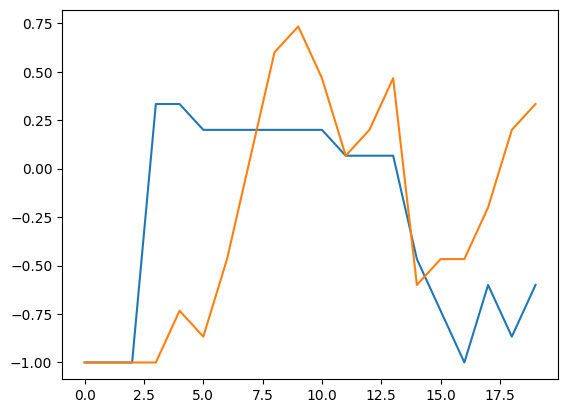

In [ ]:
plt.plot([action_grid[index][0] for index in policy])
plt.plot([action_grid[index][1] for index in policy])

In [ ]:
policy_ = []
policy_distribution_ = []
for state1 in range(state1_num):
  for state2 in range(state2_num):
    # valuelist_ = get_policy_(state1, state2, transition_mtx_normalized_, table_)[0]
    # valuelist_soft_ = [np.exp(int(x)/0.1) for x in valuelist_]
    # valuelist_soft_ = [x/np.sum(valuelist_soft_) for x in valuelist_soft_]
    # policy_distribution_.append(valuelist_soft_)
    policy_.append(get_policy_(state1, state2, transition_mtx_normalized_, table_)[1])
# for i in range(len(policy_)):
#   print(policy_[i])
  # print(policy_distribution[i])
policy_ = np.array(policy_).reshape((state1_num, state2_num))
# policy_
# policy_distribution_ = np.array(policy_distribution_).reshape((state1_num, state2_num, -1))
# np.save('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/policy_.npy', np.array(policy_))

0 0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

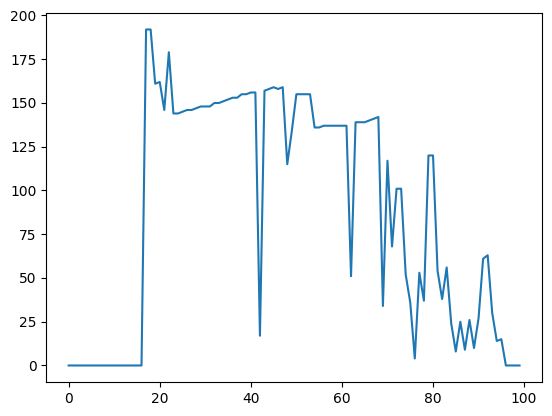

In [ ]:
policy__ = []
policy_distribution__ = []
for state in range(state_num_):
  valuelist__ = get_policy(state, transition_mtx_normalized__, table__)[0]
  valuelist_soft__ = [np.exp(int(x)/0.1) for x in valuelist__]
  valuelist_soft__ = [x/np.sum(valuelist_soft__) for x in valuelist_soft__]
  policy_distribution__.append(valuelist_soft__)
  policy__.append(get_policy(state, transition_mtx_normalized__, table__)[1])
policy_distribution__ = np.array(policy_distribution__)
plt.plot(policy__)
np.save('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/policy__.npy', np.array(policy__))

In [ ]:
policy_1206 = []
for state in range(state_num_):
  policy_1206.append(get_policy(state, transition_mtx_normalized_1206, table_1206))
for i in policy_1206:
  print(i)

[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[136, 137, 138, 139, 140, 141, 142, 143, 152, 153, 154, 155, 156, 157, 158, 168, 169, 170, 171, 172, 173, 174, 184, 185, 186, 187, 188, 189, 190, 200, 201, 202, 203, 204, 205, 206, 216, 217, 218, 219, 220, 221, 222, 232, 233, 234, 235, 236, 237, 238]
[136, 137, 138, 139, 140, 141, 142, 152, 153, 154, 155, 156, 157, 158, 168, 169, 170, 171, 172, 173, 174, 184, 185, 186, 187, 188, 189, 190, 200, 201, 202, 203, 204, 205, 206, 216, 217, 218, 219, 220, 221, 222, 232, 233, 234, 235, 236, 237, 238]
[140, 155, 157, 168, 169, 170, 171, 172, 174, 186, 188, 202, 203, 204, 218, 220, 221, 222, 235, 236]
[139, 140, 141, 142, 153, 154, 156, 157, 158, 168, 170, 171, 172, 173, 174, 185, 188, 189, 190, 202, 203, 205, 206, 219, 220, 221, 222, 233, 234, 236, 237, 238]
[142]
[139, 172]
[173, 186, 188, 202, 204, 206, 218]
[152, 155, 157, 172, 173, 187, 188, 189, 205, 206, 220, 221, 222]
[158]
[188, 190, 204]
[140, 158,

In [ ]:
start = time.time()
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
s = env.reset()
done = False
step=0
reward=0
while done == False:
  state1, state2 = state_index(s[0][0],s[0][-1])
  if len(policy_[state1, state2]) == 1:
    action_index = policy[state1][0]
  else:
    action_index = np.random.choice(policy[state1], p=np.ones(len(policy_[state1][state2]))/len(policy_[state1][state2]))
    print('noooo')
  action = action_grid[action_index]
  s,r,done,_ = env.step(action)
  reward += r
  step+=1
  print(state1, action_index)
print(reward)

TypeError: ignored

In [ ]:
start = time.time()
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
s = env.reset()
done = False
step=0
reward=0
while done == False:
  state = state_index_(s[0][0])
  if len(policy_1206[state]) == 1:
    index = policy_1206[state][0]
  else:
    index = np.random.choice(policy_1206[state], p=np.ones(len(policy_1206[state]))/len(policy_1206[state]))
    print(policy_1206[state])
  action = action_grid[index]
  s,r,done,_ = env.step(action)
  reward += r
  step+=1
print(reward)

[232, 235]
[232, 235]
[232, 235]
[154, 157, 233]
[154, 157, 233]
[154, 157, 233]
[154, 157, 233]
[154, 157, 233]
[154, 157, 233]
[154, 157, 233]
[190, 205]
[190, 205]
[190, 205]
[141, 158, 188, 202, 237]
[141, 158, 188, 202, 237]
[141, 158, 188, 202, 237]
[141, 158, 188, 202, 237]
[141, 158, 188, 202, 237]
[141, 158, 188, 202, 237]
[141, 158, 188, 202, 237]
[141, 158, 188, 202, 237]
[141, 158, 188, 202, 237]
[141, 158, 188, 202, 237]
[141, 158, 188, 202, 237]
[141, 158, 188, 202, 237]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[203, 206]
[205, 237]
[205, 237]
[205, 237]
[205, 237]
[205, 237]
[142, 206]
[142, 206]
[142, 206]
[142, 206]
[142, 206]
[142, 206]
[142, 206]
[142, 206]
[142, 206]
[142, 206]
[142, 206]
[142, 206]
[142, 206]
[142, 206]
[142, 206]
[142

1279.3153788461932
1205.19258983143
1191.6384630062455


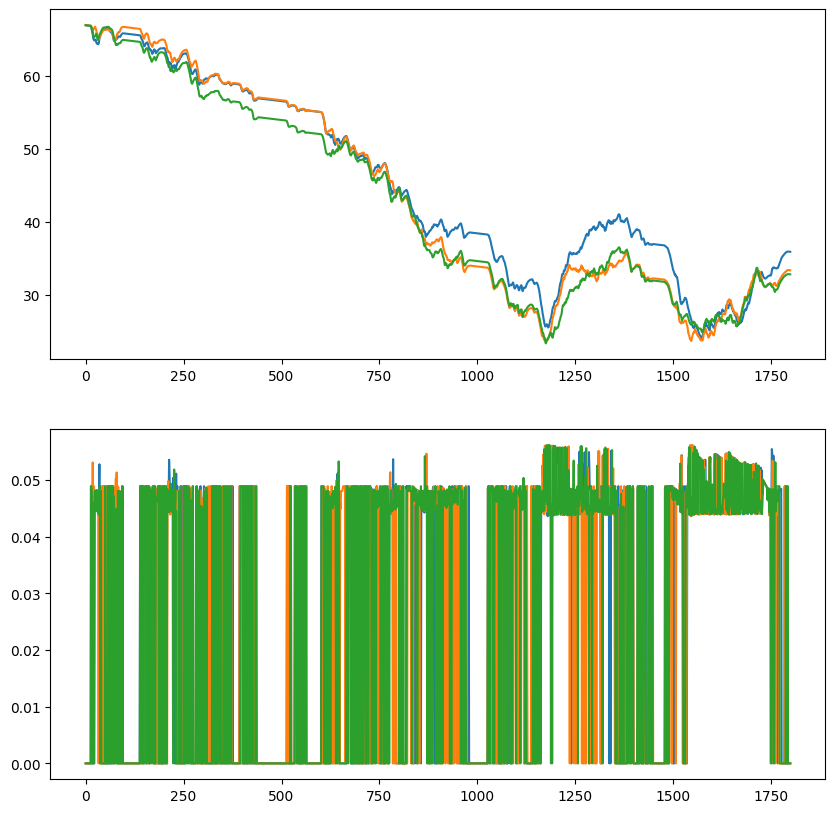

In [ ]:
start = time.time()
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
plt.figure(figsize = (10,10))
for i in range(3):
  s = env.reset()
  done = False
  step=0
  reward=0
  soclist = []
  bsfclist = []
  while done == False:
    if i == 1:
      state1, state2 = state_index(s[0][0], s[0][-1])
      action_index = np.random.choice(np.arange(len(action_grid)),p = policy_distribution_[state1][state2])
    elif i == 0:
      state1, state2 = state_index(s[0][0],s[0][-1])
      action_index = np.random.choice(np.arange(len(action_grid)), p = policy_distribution[state1])
    else:
      state = state_index_(s[0][0])
      action_index = np.random.choice(np.arange(len(action_grid)), p = policy_distribution__[state])
    s,r,done,_ = env.step(action_grid[action_index])
    soclist.append(s[0][0])
    bsfclist.append(s[0][1])
    reward += r
    step+=1
  print(reward)
  soclist = [soc*5000 for soc in soclist]

  plt.subplot(2,1,1)
  plt.plot(soclist)
  plt.subplot(2,1,2)
  plt.plot(bsfclist)
plt.show()

1716.4811349412937


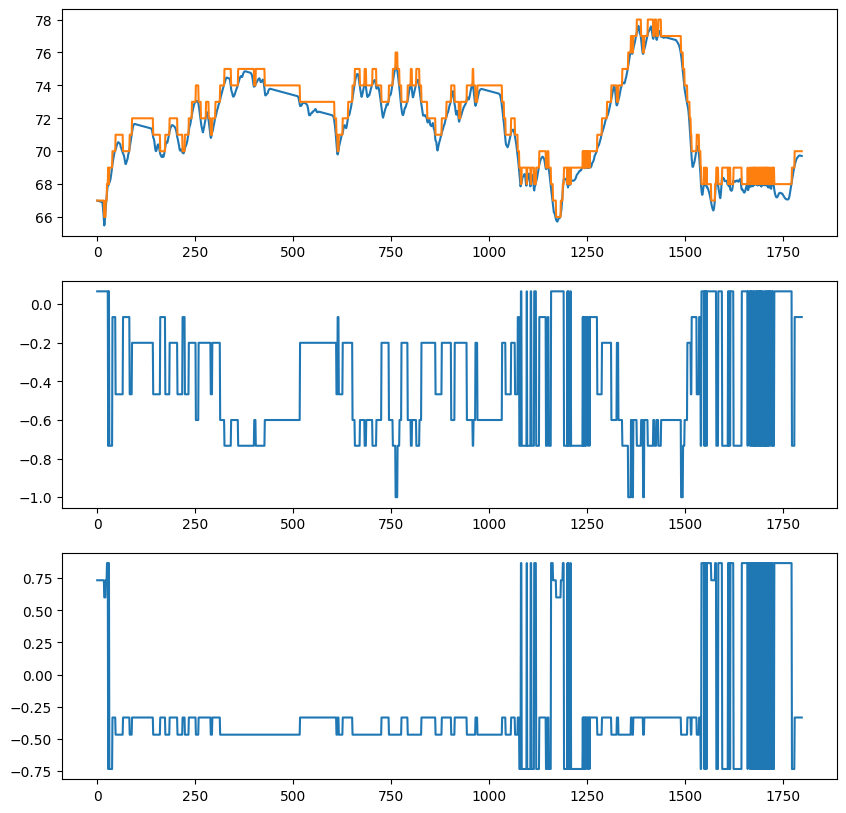

In [ ]:
start = time.time()
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
plt.figure(figsize = (10,10))
for i in range(1):
  s = env.reset()
  done = False
  step=0
  reward=0
  soclist = []
  index_list = []
  a1list = []
  a2list = []
  while done == False:
    state = state_index_(s[0][0])
    action_index = policy__[state]
    action = action_grid[action_index]
    s,r,done,_ = env.step(action)
    soclist.append(s[0][0])
    a1list.append(action[0])
    a2list.append(action[1])
    reward += r
    step+=1
    index_list.append(state)
  print(reward)
  soclist = [soc*5000 for soc in soclist]
  # index_list = [index for index in index_list]
  plt.subplot(3,1,1)
  plt.plot(soclist)
  plt.plot(index_list)
  plt.subplot(3,1,2)
  plt.plot(a1list)
  plt.subplot(3,1,3)
  plt.plot(a2list)
plt.show()

prev :  0 index :  136 curr : 14
0.0 0 14
prev :  14 index :  187 curr : 13
0.0036635006784260515 14 13
prev :  13 index :  237 curr : 12
0.004615384615384616 13 12
prev :  12 index :  187 curr : 11
0.004254532001479837 12 11
prev :  11 index :  169 curr : 10
0.003941730934018852 11 10
prev :  10 index :  232 curr : 11
0.004414199006805224 10 11
prev :  11 index :  137 curr : 10
0.017932489451476793 11 10
prev :  10 index :  232 curr : 9
0.004414199006805224 10 9
prev :  9 index :  235 curr : 8
0.0058823529411764705 9 8
prev :  8 index :  202 curr : 7
0.006195262609431433 8 7
prev :  7 index :  174 curr : 6
0.007367072389493914 7 6
prev :  6 index :  203 curr : 5
0.007939062332367772 6 5
prev :  5 index :  238 curr : 4
0.007465339495200853 5 4
prev :  4 index :  136 curr : 4
0.0 0 4
prev :  4 index :  140 curr : 4
0.0 0 4
prev :  4 index :  141 curr : 4
0.0 0 4
prev :  4 index :  190 curr : 5
0.007399186089530152 4 5
prev :  5 index :  170 curr : 4
0.0045449380752187254 5 4
prev :  4 i

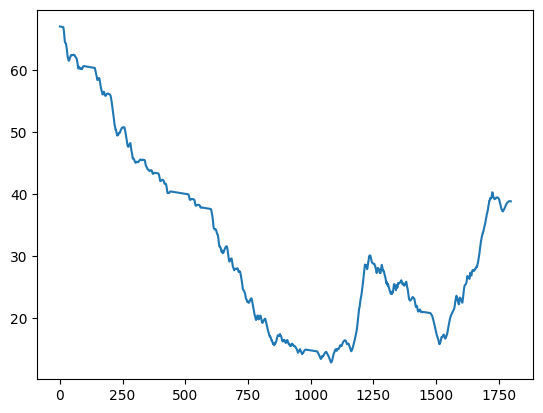

In [ ]:
start = time.time()
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
# plt.figure(figsize = (10,10))
soclist =[]
for i in range(1):
  s = env.reset()
  prev = 0
  done = False
  step=0
  reward=0
  while done == False:
    state1, state2 = state_index(s[0][0],s[0][-1])
    action = [np.random.rand()*(-1)**np.random.randint(0,1), np.random.rand()*(-1)**np.random.randint(0,1)]
    index = action_index(action)
    s,r,done,_ = env.step(action)
    if np.argmax(transition_mtx[prev][index])!=state1:
      print('prev : ', prev, 'index : ',index, 'curr :', state1)
      print(np.max(transition_mtx_normalized[prev][index][:]),np.argmax(transition_mtx[prev][index][:]),state1)
    reward += r
    step+=1
    prev = state1
    soclist.append(s[0][0])
  print(reward)
  soclist = [soc*5000 for soc in soclist]
  # index_list = [index for index in index_list]
  plt.plot(soclist)
plt.show()

In [ ]:
np.random.random()

TypeError: ignored

0

In [ ]:
policy_list

[[0,
  0,
  0,
  160,
  162,
  145,
  148,
  152,
  156,
  157,
  155,
  136,
  137,
  139,
  67,
  36,
  4,
  54,
  25,
  58],
 array([[  0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 193, 161, 194, 196, 192],
        [160, 176, 164, 177, 197, 192,  65],
        [144, 212, 160, 145, 205, 176, 129],
        [147,  67, 150, 132, 178, 202, 150],
        [169, 167, 220, 151, 204, 171, 171],
        [150, 147, 155, 141, 233, 134, 170],
        [133,  73, 156, 175, 254, 153,  35],
        [156, 157, 120,  59, 136, 115, 155],
        [ 32, 128,  88,  49, 135, 136, 102],
        [150,   1,  48,  66,  51,   3, 137],
        [  1,  96, 125,  82,  19,  68,  86],
        [ 32,  10, 100, 142,   3,  20,  70],
        [  2, 118, 119,  68,  36, 138, 103],
        [ 86,  85,  63,   4,  87,   5,  71],
        [ 39,   5,   5,  87,  71, 121,  88],
        [110,  58,  39,  71,   6,  74,  57],
        [ 44,  77

1708.4144594560407


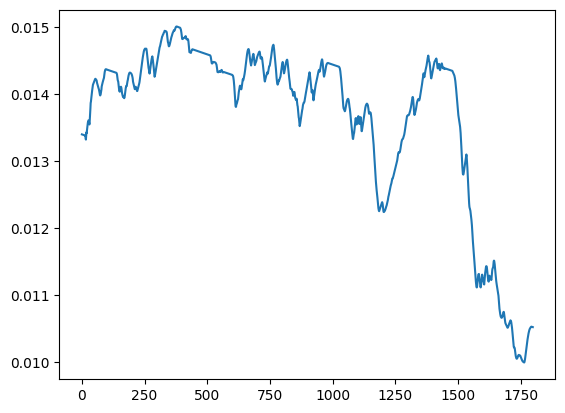

In [ ]:
start = time.time()
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
s = env.reset()
done = False
step=0
reward=0
soclist_=[]

while done == False:
  state1, state2 = state_index(s[0][0], s[0][-1])
  action_index = policy_[state1, state2]
  # action_index = np.random.choice(np.arange(len(action_grid)), p=policy_distribution_[state1, state2])
  # action = action_list[step]
  # if policy[state1] == 0:
  #   action_index = prev_index
  # else:
  #   action_index = policy[state1]
  s,r,done,_ = env.step(action_grid[action_index])
  soclist_.append(s[0][0])
  # state1, state2 = state_index(s[0][0],s[0][-1])
  reward += r
  step+=1
  prev_index = action_index
print(reward)
plt.plot(soclist_)

1716.4811349412937


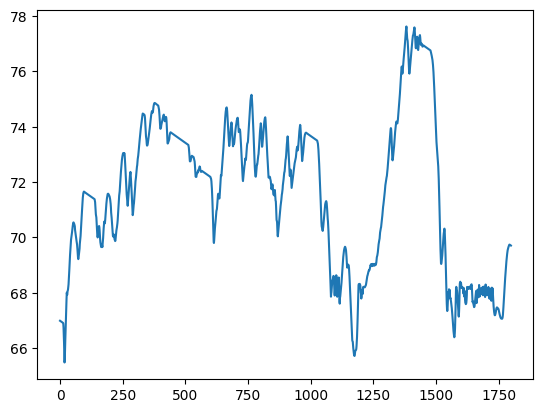

In [ ]:
start = time.time()
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
s = env.reset()
done = False
step=0
reward=0
soclist__=[]

while done == False:
  state = state_index_(s[0][0])
  action_index = policy__[state]
  s,r,done,_ = env.step(action_grid[action_index])
  soclist__.append(s[0][0])
  reward += r
  step+=1
  prev_index = action_index
print(reward)
soclist__real = [soc*5000 for soc in soclist__]
plt.plot(soclist__real)